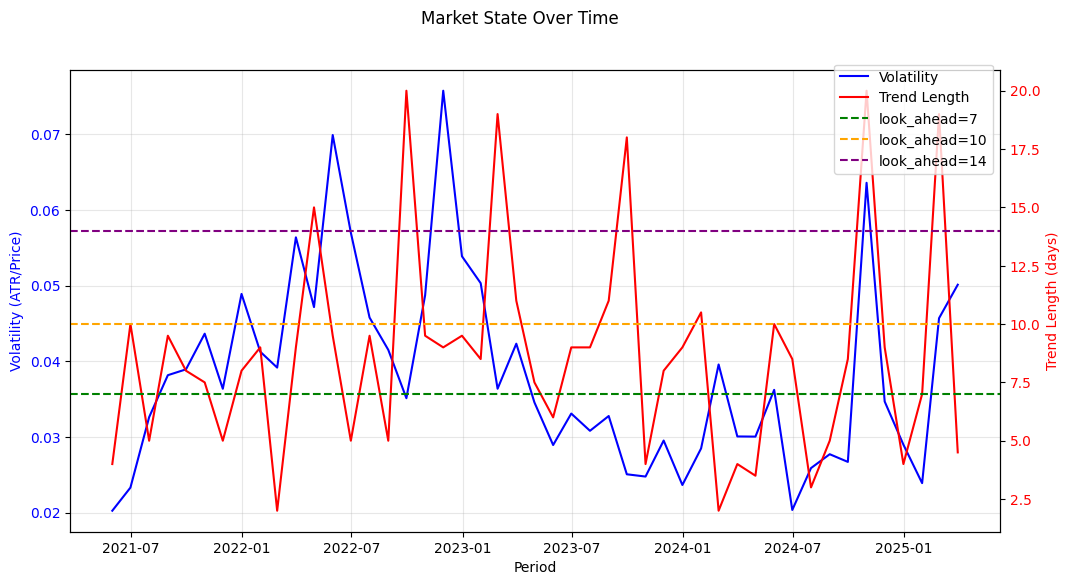

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

C:\Users\wzzha\AppData\Local\Temp\ipykernel_18020\631239602.py:202: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / freqs


100%|██████████| 300/300 [00:30<00:00,  9.85trial/s, best loss: -2.5]              
Support Reversal for data_HK_09988_20250316.csv:
Recommended look_ahead for 2025-03-31 00:00:00+08:00: 7 days
Pre-calculated: look_ahead=7, target_multiplier=1.16, atr_period=52
Best Parameters: {'fast_period': 5, 'slow_period': 12, 'signal_period': 3, 'support_ma_period': 55, 'resistance_ma_period': 30}
Overall Support Reversal Win Rate: 81.25% (Signals: 16)
Overall Resistance Reversal Win Rate: 66.67% (Signals: 6)


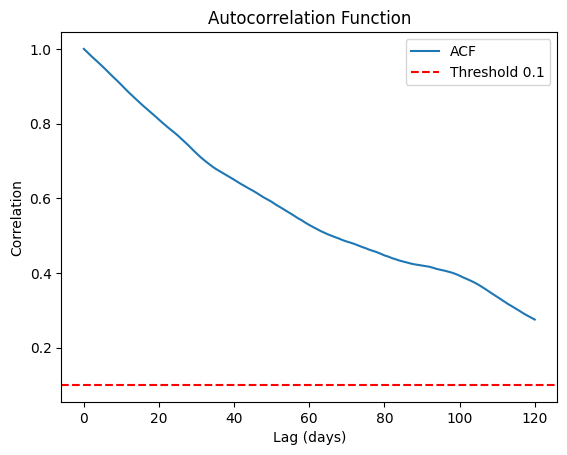

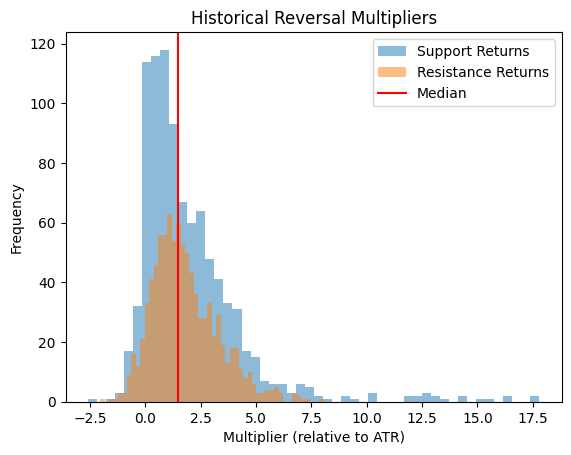

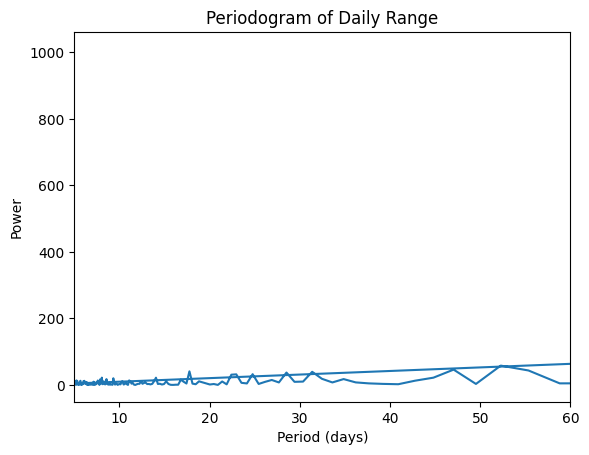

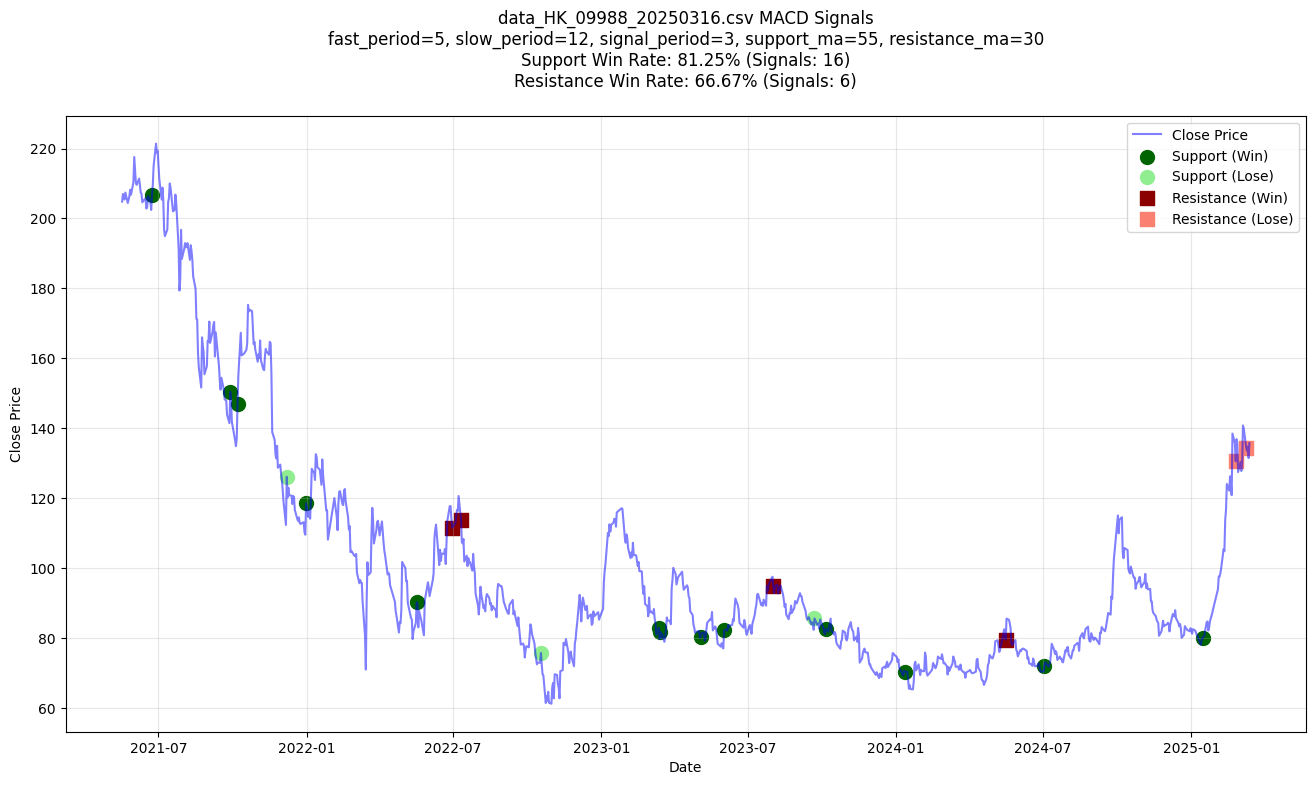

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from hyperopt import hp, fmin, tpe, Trials
from IPython.display import display
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram, argrelextrema
import os

# 数据文件路径
data_dir = '../data'
csv_filename = 'data_HK_09988_20250316.csv'
csv_path = os.path.join(data_dir, csv_filename)

# 读取本地CSV文件
df = pd.read_csv(csv_path, index_col=0, parse_dates=True)

# ATR计算（矢量化）
def ATR(high, low, close, period=14):
    tr = pd.DataFrame(index=high.index)
    tr['HL'] = high - low
    tr['HC'] = abs(high - close.shift(1))
    tr['LC'] = abs(low - close.shift(1))
    tr['TR'] = tr[['HL', 'HC', 'LC']].max(axis=1)
    return tr['TR'].rolling(window=int(period), min_periods=1).mean()

# Numba加速未来范围计算
@njit
def get_future_range_numba(series, look_ahead, is_high=True):
    future_values = np.full(len(series), np.nan)
    for i in range(len(series) - look_ahead):
        if is_high:
            future_values[i] = np.max(series[i+1:i+1+look_ahead])
        else:
            future_values[i] = np.min(series[i+1:i+1+look_ahead])
    return future_values

def calculate_trend_duration(df, min_return=0.001, smooth_window=3):
    smoothed_returns = df['close'].pct_change().rolling(window=smooth_window, min_periods=1).mean()
    trends = []
    current_trend = 0
    
    for ret in smoothed_returns.dropna():
        if ret >= min_return and current_trend >= 0:
            current_trend += 1
        elif ret <= -min_return and current_trend <= 0:
            current_trend -= 1
        elif (ret > min_return and current_trend < 0) or (ret < -min_return and current_trend > 0):
            if abs(current_trend) >= 2:
                trends.append(abs(current_trend))
            current_trend = 1 if ret > min_return else -1
        else:
            if abs(current_trend) >= 2:
                trends.append(abs(current_trend))
            current_trend = 0
    
    if abs(current_trend) >= 2:
        trends.append(abs(current_trend))
    
    return trends

# 按时间段分析市场状态
def analyze_market_states(df, period='Q'):  # 'Q' 为季度，'Y' 为年度
    df['date'] = df.index
    grouped = df.groupby(pd.Grouper(key='date', freq=period))
    
    volatility = []
    trend_length = []
    periods = []
    
    for name, group in grouped:
        # 计算波动性（标准化 ATR）
        atr = ATR(group['high'], group['low'], group['close'], period=36)
        vol = atr.mean() / group['close'].mean()  # 波动性相对价格
        volatility.append(vol)
        
        # 计算趋势长度（中位数）
        trends = calculate_trend_duration(group, min_return=0, smooth_window=10)
        trend_len = np.median(trends) if trends else 10
        trend_length.append(trend_len)
        
        periods.append(name)
    
    return pd.DataFrame({
        'Period': periods,
        'Volatility': volatility,
        'Trend_Length': trend_length
    })

# 绘制状态图表
def plot_market_states(df_states):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # 波动性（左轴）
    ax1.plot(df_states['Period'], df_states['Volatility'], color='blue', label='Volatility')
    ax1.set_xlabel('Period')
    ax1.set_ylabel('Volatility (ATR/Price)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, alpha=0.3)
    
    # 趋势长度（右轴）
    ax2 = ax1.twinx()
    ax2.plot(df_states['Period'], df_states['Trend_Length'], color='red', label='Trend Length')
    ax2.set_ylabel('Trend Length (days)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # 添加参考线
    ax2.axhline(7, color='green', linestyle='--', label='look_ahead=7')
    ax2.axhline(10, color='orange', linestyle='--', label='look_ahead=10')
    ax2.axhline(14, color='purple', linestyle='--', label='look_ahead=14')
    
    fig.suptitle('Market State Over Time')
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

# 趋势持续时间分布
def plot_trend_duration_distribution(df, min_return=0.001, smooth_window=3):
    trends = calculate_trend_duration(df, min_return, smooth_window)
    mean_duration = np.mean(trends) if trends else 10
    median_duration = np.median(trends) if trends else 10
    
    plt.figure(figsize=(10, 6))
    plt.hist(trends, bins=30, color='blue', alpha=0.7, label='Trend Duration Distribution')
    plt.axvline(mean_duration, color='red', linestyle='--', label=f'Mean: {mean_duration:.1f} days')
    plt.axvline(median_duration, color='green', linestyle='--', label=f'Median: {median_duration:.1f} days')
    plt.title(f'Trend Duration Distribution (smooth_window={smooth_window}, min_return={min_return})')
    plt.xlabel('Duration (days)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return mean_duration, median_duration

def determine_look_ahead(volatility, trend_length):
    # look_ahead简洁参考规则
    # 规则 1：根据波动性和趋势长度选择 look_ahead
    # 高波动 + 短趋势（震荡行情）：
    # 波动性 > 0.03，且趋势长度 < 7 天。
    # 推荐 look_ahead：7 天。
    # 理由：捕捉快速顶底，信号密集，适合每周 2-3 次（每月 ≈ 10-15 次）。
    # 适用标的：高波动个股（如科技股）、震荡期指数。
    # 低波动 + 长趋势（趋势行情）：
    # 波动性 < 0.02，且趋势长度 > 10 天。
    # 推荐 look_ahead：14 天。
    # 理由：减少无效信号，确认趋势反转，信号频率降低（每月 ≈ 5-10 次）。
    # 适用标的：低波动指数（如蓝筹股指数）、趋势期市场。
    # 中等波动 + 中等趋势（混合行情）：
    # 波动性 0.02-0.03，或趋势长度 7-10 天。
    # 推荐 look_ahead：10 天。
    # 理由：平衡胜率和召回率，信号频率适中（每月 ≈ 7-12 次）。
    # 适用标的：中波动指数（如上证综指）、混合期市场。
    # 规则 2：调整信号频率
    # 如果信号频率过高（每月 > 15 次）：
    # 增加 strength_threshold（如 0.1 → 0.2），减少信号数量。
    # 或缩短 atr_period_explicit 和 atr_period_hidden（如 45 → 20），提高信号质量。
    # 如果信号频率过低（每月 < 5 次）：
    # 降低 strength_threshold（如 0.2 → 0.1），增加信号数量。
    # 或延长 look_ahead（如 7 → 10），捕捉更多反转。
    # 规则 3：通用性扩展
    # 高波动标的（个股或高风险资产）：
    # 默认波动性阈值可放宽（> 0.04 算高波动），趋势长度阈值缩短（< 5 天）。
    # 低波动标的（债券指数或稳定资产）：
    # 默认波动性阈值收紧（< 0.015 算低波动），趋势长度阈值延长（> 12 天）。
    # 调整范围：
    # 波动性范围：0.01-0.06（灵活调整）。
    # 趋势长度范围：3-20 天（根据分布调整）。
    if volatility > 0.03 and trend_length < 7:
        return 7
    elif volatility < 0.02 and trend_length > 10:
        return 14
    else:
        return 10

# 分析市场状态(每月)
df_states = analyze_market_states(df, period='ME')
plot_market_states(df_states)

# 测试不同参数
# for smooth_window in [5, 10, 20, 30, 60]:
#     for min_return in [0]:
#         mean_duration, median_duration = plot_trend_duration_distribution(df, min_return=min_return, smooth_window=smooth_window)
#         print(f"smooth_window={smooth_window}, min_return={min_return}: Mean={mean_duration:.1f}, Median={median_duration:.1f}")

def calculate_target_multiplier(df, atr_period=20, look_ahead=10):
    df = df.copy()
    atr = ATR(df['high'], df['low'], df['close'], period=atr_period)
    df['atr'] = atr
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    support_returns = (df['future_high'] - df['close']) / df['atr']
    resistance_returns = (df['close'] - df['future_low']) / df['atr']
    valid_returns = pd.concat([support_returns.dropna(), resistance_returns.dropna()])
    
    return np.median(valid_returns) if len(valid_returns) > 0 else 1.0

def calculate_atr_period(df, max_period=60):
    daily_range = df['high'] - df['low']
    freqs, power = periodogram(daily_range.dropna())
    periods = 1 / freqs
    valid_idx = np.where((periods > 5) & (periods <= max_period))
    dominant_period = periods[valid_idx][np.argmax(power[valid_idx])]
    return int(dominant_period) if dominant_period else 20

# MACD计算
def MACD(close, fast_period=12, slow_period=26, signal_period=9):
    # 计算快线和慢线的EMA
    ema_fast = close.ewm(span=fast_period, adjust=False).mean()
    ema_slow = close.ewm(span=slow_period, adjust=False).mean()
    
    # 计算MACD线（快线-慢线）
    macd_line = ema_fast - ema_slow
    
    # 计算信号线（MACD的移动平均）
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    
    # 计算MACD柱状图
    macd_hist = macd_line - signal_line
    
    return macd_line, signal_line, macd_hist

# 用atr_period计算 target_multiplier
atr_period = calculate_atr_period(df)
current_state = df_states.iloc[-1] # 最近一个月市场状态
currnet_look_ahead = determine_look_ahead(current_state['Volatility'], current_state['Trend_Length'])
look_ahead = currnet_look_ahead # 根据近期Trend Duration Distribution估计
target_multiplier = calculate_target_multiplier(df, atr_period=atr_period, look_ahead=look_ahead)

def crossover_status(series_a: pd.Series, series_b: pd.Series) -> list:
    """判断series_a对series_b的上穿、下穿或不相交状态。
    返回: [1: 上穿, -1: 下穿, 0: 不相交]"""
    if len(series_a) != len(series_b):
        raise ValueError("两个Series必须等长")
    status = [0]  # 第一个位置无前值
    for i in range(1, len(series_a)):
        if series_a.iloc[i-1] <= series_b.iloc[i-1] and series_a.iloc[i] > series_b.iloc[i]:
            status.append(1)  # 上穿
        elif series_a.iloc[i-1] >= series_b.iloc[i-1] and series_a.iloc[i] < series_b.iloc[i]:
            status.append(-1)  # 下穿
        else:
            status.append(0)  # 不相交
    return status

def detect_divergence(indicator_a: pd.Series, indicator_b: pd.Series, price: pd.Series, 
                      golden_crosses: list = None, dead_crosses: list = None) -> pd.Series:
    """通用背离检测函数，接受预计算的交叉点"""
    divergence = pd.Series(0, index=price.index)
    idxs = price.index.to_list()

    # 获取交叉状态并提取金叉和死叉索引
    if golden_crosses is None or dead_crosses is None:
        crossover = crossover_status(indicator_a, indicator_b)
        golden_crosses = [i for i, c in enumerate(crossover) if c == 1]  # 金叉索引
        dead_crosses = [i for i, c in enumerate(crossover) if c == -1]  # 死叉索引

    # 顶背离检测
    for i in range(1, len(dead_crosses)):
        last_dc, prev_dc = dead_crosses[-i], dead_crosses[-i-1]
        gc = next((g for g in reversed(golden_crosses) if prev_dc < g < last_dc), None)
        if gc:
            max_price_curr = price.iloc[gc:last_dc+1].max()
            max_a_curr = indicator_a.iloc[gc:last_dc+1].max()
            prev_gc = next((g for g in reversed(golden_crosses) if g < prev_dc), None)
            if prev_gc:
                max_price_prev = price.iloc[prev_gc:prev_dc+1].max()
                max_a_prev = indicator_a.iloc[prev_gc:prev_dc+1].max()
                if max_price_curr > max_price_prev and max_a_curr < max_a_prev:
                    divergence.loc[idxs[last_dc]] = 1  # 标记顶背离

    # 底背离检测
    for i in range(1, len(golden_crosses)):
        last_gc, prev_gc = golden_crosses[-i], golden_crosses[-i-1]
        dc = next((d for d in reversed(dead_crosses) if prev_gc < d < last_gc), None)
        if dc:
            min_price_curr = price.iloc[dc:last_gc+1].min()
            min_a_curr = indicator_a.iloc[dc:last_gc+1].min()
            prev_dc = next((d for d in reversed(dead_crosses) if d < prev_gc), None)
            if prev_dc:
                min_price_prev = price.iloc[prev_dc:prev_gc+1].min()
                min_a_prev = indicator_a.iloc[prev_dc:prev_gc+1].min()
                if min_price_curr < min_price_prev and min_a_curr > min_a_prev:
                    divergence.loc[idxs[last_gc]] = -1  # 标记底背离

    return divergence

def detect_macd_signals_vectorized(df, fast_period=12, slow_period=26, signal_period=9, 
                                 support_ma_period=20, resistance_ma_period=20, lookback=20):
    df = df.copy()
    
    # 计算MACD
    macd_line, signal_line, _ = MACD(df['close'], 
                                    fast_period=fast_period, 
                                    slow_period=slow_period, 
                                    signal_period=signal_period)
    
    # 计算支撑和阻力均线
    df['support_ma'] = df['close'].rolling(window=support_ma_period, min_periods=1).mean()
    df['resistance_ma'] = df['close'].rolling(window=resistance_ma_period, min_periods=1).mean()
    
    df['DIF'] = macd_line
    df['DEA'] = signal_line
    
    # 获取交叉点
    crossover = crossover_status(df['DIF'], df['DEA'])
    golden_crosses = [i for i, c in enumerate(crossover) if c == 1]
    dead_crosses = [i for i, c in enumerate(crossover) if c == -1]
    
    # 检测背离
    divergence = detect_divergence(df['DIF'], df['DEA'], df['close'], 
                                 golden_crosses, dead_crosses)
    
    # 设置信号
    df['divergence_signal'] = divergence
    
    # 根据支撑/阻力均线过滤信号
    for idx in df.index:
        if df.loc[idx, 'divergence_signal'] == 1:  # 顶背离
            if df.loc[idx, 'close'] <= df.loc[idx, 'resistance_ma']:
                df.loc[idx, 'divergence_signal'] = 0
        elif df.loc[idx, 'divergence_signal'] == -1:  # 底背离
            if df.loc[idx, 'close'] >= df.loc[idx, 'support_ma']:
                df.loc[idx, 'divergence_signal'] = 0
    
    # 设置信号描述
    df['reversal'] = df['divergence_signal'].map({
        1: 'resistance reversal',
        -1: 'support reversal',
        0: 'none'
    })
    
    return df

def calculate_win_rate(df, look_ahead=10, target_multiplier=1, atr_period=20):
    df = df.copy()
    df['atr'] = ATR(df['high'], df['low'], df['close'], period=atr_period)
    
    df['support_target'] = df['close'] + df['atr'] * target_multiplier
    df['resistance_target'] = df['close'] - df['atr'] * target_multiplier
    
    df['future_high'] = get_future_range_numba(df['high'].values, look_ahead, is_high=True)
    df['future_low'] = get_future_range_numba(df['low'].values, look_ahead, is_high=False)
    
    df['support_win'] = np.where(
        (df['reversal'] == 'support reversal') & (df['future_high'] >= df['support_target']),
        1, 0
    )
    df['resistance_win'] = np.where(
        (df['reversal'] == 'resistance reversal') & (df['future_low'] <= df['resistance_target']),
        1, 0
    )
    
    support_signals = df[df['reversal'] == 'support reversal']
    resistance_signals = df[df['reversal'] == 'resistance reversal']
    support_win_rate = support_signals['support_win'].mean() if len(support_signals) > 0 else 0
    resistance_win_rate = resistance_signals['resistance_win'].mean() if len(resistance_signals) > 0 else 0
    
    return {
        'support_win_rate': support_win_rate,
        'support_signals_count': len(support_signals),
        'resistance_win_rate': resistance_win_rate,
        'resistance_signals_count': len(resistance_signals),
        'detailed_df': df
    }

# 参数空间
space = {
    'fast_period': hp.quniform('fast_period', 5, 25, 1),  #聚焦有效范围
    'slow_period': hp.quniform('slow_period', 2, 5, 0.5),
    # 'signal_period': hp.quniform('signal_period', 3, 18, 1),
    'signal_period': hp.quniform('signal_period', 0.5, 1, 0.1),
    'support_ma_period': hp.quniform('support_ma_period', 10, 60, 5),
    'resistance_ma_period': hp.quniform('resistance_ma_period', 10, 60, 5)
}

signal_count_target = len(df)

# 目标函数，调整优化目标以保留更多信号
def objective(params):
    # 转换为整数值
    params_int = {
        'fast_period': int(params['fast_period']),
        # 'slow_period': int(params['slow_period']),
        'slow_period': int(params['slow_period'] * params['fast_period']),
        # 'signal_period': int(params['signal_period']),
        'signal_period': int(params['signal_period'] * int(params['fast_period'])),
        'support_ma_period': int(params['support_ma_period']),
        'resistance_ma_period': int(params['resistance_ma_period'])
    }
    df_with_signals = detect_macd_signals_vectorized(df.copy(), **params_int)
    result = calculate_win_rate(df_with_signals, look_ahead=look_ahead, target_multiplier=target_multiplier, atr_period=atr_period)
    
    # 计算F1
    beta = 2
    support_precision = result['support_win_rate']
    resistance_precision = result['resistance_win_rate']
    
    score = (support_precision + resistance_precision) / 2
    
    # 添加信号数量惩罚项
    signal_count_penalty = min(result['support_signals_count'], result['resistance_signals_count'])
    adjusted_score = score * signal_count_penalty
    # adjusted_score = score

    return -adjusted_score  # 负值用于最小化

# 执行贝叶斯优化
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=300, trials=trials)

# 将best参数转换为实际值
best_params = {
    'fast_period': int(best['fast_period']),
    # 'slow_period': int(best['slow_period']),
    'slow_period': int(best['slow_period'] * best['fast_period']),
    # 'signal_period': best['signal_period'],
    'signal_period': int(best['signal_period'] * int(best['fast_period'])),
    'support_ma_period': int(best['support_ma_period']),
    'resistance_ma_period': int(best['resistance_ma_period'])
}

# 使用最佳参数计算最终信号
df = detect_macd_signals_vectorized(df, **best_params)
result = calculate_win_rate(df)

# 输出结果
# display(df_states.tail(20))
print(f"Support Reversal for {csv_filename}:")
print(f"Recommended look_ahead for {current_state['Period']}: {currnet_look_ahead} days")
print(f"Pre-calculated: look_ahead={look_ahead}, target_multiplier={target_multiplier:.2f}, atr_period={atr_period}")
print(f"Best Parameters: {best_params}")
print(f"Overall Support Reversal Win Rate: {result['support_win_rate']:.2%} (Signals: {result['support_signals_count']})")
print(f"Overall Resistance Reversal Win Rate: {result['resistance_win_rate']:.2%} (Signals: {result['resistance_signals_count']})")

# 将完整DataFrame保存为CSV文件
# csv_path = '../data/stochastic_signals_optimized.csv'
# result['detailed_df'].to_csv(csv_path, index=True)
# print(f"\nDetailed DataFrame saved to: {csv_path}")

# 显示尾部12行
# print("\nDetailed DataFrame (Last 250 Rows):")
# display(result['detailed_df'][['open', 'high', 'low', 'close', 'volume', 'reversal', 'support_target', 'resistance_target', 'future_high', 'future_low', 'support_win', 'resistance_win']].tail(12))

# 可视化自相关
acf_values = acf(df['close'].dropna(), nlags=120, fft=True)
plt.plot(acf_values, label='ACF')
plt.axhline(0.1, color='r', linestyle='--', label='Threshold 0.1')
plt.title('Autocorrelation Function')
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.legend()
plt.show()

# 可视化反转幅度
atr = ATR(df['high'], df['low'], df['close'], period=20)
support_returns = (result['detailed_df']['future_high'] - df['close']) / atr
resistance_returns = (df['close'] - result['detailed_df']['future_low']) / atr
plt.hist(support_returns.dropna(), bins=50, alpha=0.5, label='Support Returns')
plt.hist(resistance_returns.dropna(), bins=50, alpha=0.5, label='Resistance Returns')
plt.axvline(np.median(pd.concat([support_returns.dropna(), resistance_returns.dropna()])), color='r', label='Median')
plt.title('Historical Reversal Multipliers')
plt.xlabel('Multiplier (relative to ATR)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 可视化周期图
freqs, power = periodogram(df['high'] - df['low'])
# 过滤掉零频率
valid_freqs = np.where(freqs == 0, 1, freqs)
periods = 1 / valid_freqs
plt.plot(periods, power)
plt.xlim(5, 60)
# plt.ylim(-1000, 50000)
plt.title('Periodogram of Daily Range')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

df_visual = result['detailed_df']
plt.figure(figsize=(16, 8))
plt.plot(df_visual.index, df_visual['close'], label='Close Price', color='blue', alpha=0.5)

# 显性强信号
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['support_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['support_win'] == 1)]['close'],
            color='darkgreen', marker='o', label='Support (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['support_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'support reversal') & (df_visual['support_win'] == 0)]['close'],
            color='lightgreen', marker='o', label='Support (Lose)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['resistance_win'] == 1)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['resistance_win'] == 1)]['close'],
            color='darkred', marker='s', label='Resistance (Win)', s=100)
plt.scatter(df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['resistance_win'] == 0)].index,
            df_visual[(df_visual['reversal'] == 'resistance reversal') & (df_visual['resistance_win'] == 0)]['close'],
            color='salmon', marker='s', label='Resistance (Lose)', s=100)

# 增强标题信息
title = (
    f'{csv_filename} MACD Signals\n'
    f'fast_period={best_params["fast_period"]}, slow_period={best_params["slow_period"]}, signal_period={best_params["signal_period"]}, support_ma={best_params["support_ma_period"]}, resistance_ma={best_params["resistance_ma_period"]}\n'
    f'Support Win Rate: {result["support_win_rate"]:.2%} (Signals: {result["support_signals_count"]})\n'
    f'Resistance Win Rate: {result["resistance_win_rate"]:.2%} (Signals: {result["resistance_signals_count"]})\n'
)
plt.title(title, fontsize=12)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.show()